# Importation des différents packages et téléchargement de la structure de bande

In [2]:
import pymatgen as mp
import numpy as np
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen import MPRester
from pymatgen.io.cif import CifWriter
from pymatgen.electronic_structure.bandstructure import BandStructureSymmLine
from matplotlib import pyplot as plt

from pymatgen.phonon.bandstructure import PhononBandStructure, PhononBandStructureSymmLine

from pymatgen.electronic_structure.plotter import DosPlotter, BSPlotter, \
    plot_ellipsoid, fold_point, plot_brillouin_zone, BSPlotterProjected, \
    BSDOSPlotter, CohpPlotter, BoltztrapPlotter

# Tout d'abord, on télécharge la structure de bande du matériau qui nous a été attribué (et le fichier CIF au passage)

with MPRester("6gQTbf2KhBi8mC40") as m:
    
    # Structure for material id
    structure = m.get_structure_by_material_id("mp-9166")
    new_s = SpacegroupAnalyzer(structure).get_primitive_standard_structure()
    w = CifWriter(new_s)
    CIF = w.write_file('MgCN2.cif')

    # Bandstructure for material id
    bandstructure = m.get_bandstructure_by_material_id("mp-9166")

# Caractérisation de la bande interdite

En utilisant la fonction get_band_gap(), nous pouvons déterminer la bande interdite du matériau

In [3]:
bande_interdite = bandstructure.get_band_gap()
print(bande_interdite)
gap_energie = bande_interdite["energy"]
print(gap_energie)

{'direct': False, 'energy': 3.759, 'transition': 'Z-L'}
3.759


On se rend compte que la bande interdite n'est pas directe, que la valeur du gap d'énergie est de 3.759 eV.
La bande interdite n'étant pas directe, le troisième argument du résultat que nous renvoie "get_band_gap()" nous donne les vecteurs k pour lesquels la transition se fait. Le maximum de la bande de valence apparaît pour un vecteur d'onde d'indcice Z et le minimum de la bande de conduction apparaît pour un vecteur d'onde d'indice L.

<module 'matplotlib.pyplot' from '/usr/local/lib64/python3.6/site-packages/matplotlib/pyplot.py'>

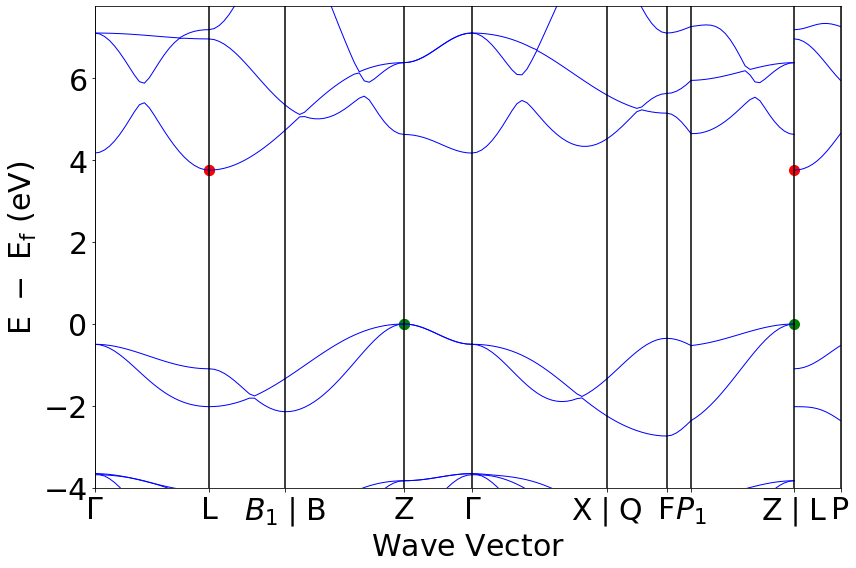

In [4]:
plotter = BSPlotter(bandstructure)
plotter.get_plot(vbm_cbm_marker = True)

# Etude de la dispersion dans les bandes de valences et conduction

In [5]:
nbre_bande = bandstructure.nb_bands
print("Mon matériau possède: ", nbre_bande, "bandes et 9 branches")

Mon matériau possède:  24 bandes et 9 branches


In [6]:
cbm = bandstructure.get_cbm() 
print(cbm)

{'band_index': defaultdict(<class 'list'>, {<Spin.up: 1>: [11]}), 'kpoint_index': [23, 24, 149], 'kpoint': <pymatgen.electronic_structure.bandstructure.Kpoint object at 0x7f5a9d03af28>, 'energy': 6.5313, 'projections': {}}


On peut voir que la première bande de conduction est ma 11ème bande sur 24

In [7]:
vbm = bandstructure.get_vbm()
print(vbm)

{'band_index': defaultdict(<class 'list'>, {<Spin.up: 1>: [9, 10]}), 'kpoint_index': [64, 65, 148], 'kpoint': <pymatgen.electronic_structure.bandstructure.Kpoint object at 0x7f5a9abd3908>, 'energy': 2.7723, 'projections': {}}


Tandis qu'ici, on remarque que ma dernière bande de valence est la 10ème bande sur 24.

Une fois qu'on a tout cela, on va pouvoir choisir les bandes sur lesquelles on va travailler et analyser les pentes entre deux branches. Cela nous permettra d'avoir la dispersion maximale et minimale pour chacune de la première bande de conduction et de la dernière bande de valence. Pour déterminer la pente, ayant beaucoup de valeur à analyser nous allons utiliser la fonction suivante: pente(), qui permet de calculer la pente d'une drroite sur base de 2 points.

In [8]:
from scipy.stats import linregress
# On utilise plotter.bs_plot_data()[élément que l'on veut][branche][spin up = 1, spin down = 0][bande]
def pente(bande):
    res = np.zeros(9)
    for i in range(9):
        y = (plotter.bs_plot_data()['energy'][i]['1'][bande][-1]) - (plotter.bs_plot_data()['energy'][i]['1'][bande][0]) 
        x = (plotter.bs_plot_data()['distances'][i][-1]) - (plotter.bs_plot_data()['distances'][i][0])
        pente = np.abs(y)/x
        res[i] = pente
    return(res)
print(pente(10))
print(pente(11))

[0.53448809 0.33728973 1.15265167 0.74779841 0.63757778 1.69391978
 0.74320927 0.52253681 1.25796612]
[0.37174017 1.31020434 0.08049939 0.68627356 0.26368677 1.07652902
 2.09407921 0.0208103  1.97908472]


In [9]:
#Test du calcul de la pente pour vérifier la boucle for après
y1 = plotter.bs_plot_data()['energy'][0]['1'][10][0]
y2 = plotter.bs_plot_data()['energy'][0]['1'][10][-1]
x1 = plotter.bs_plot_data()['distances'][0][0]
x2 = plotter.bs_plot_data()['distances'][0][-1]

pente_0 = np.abs((y2-y1))/(x2-x1)
print(pente_0)

0.5344880948491385


In [10]:
pente_max_vb = np.max(pente(10))
pente_min_vb = np.min(pente(10))
pente_max_cb = np.max(pente(11))
pente_min_cb = np.min(pente(11))


print(pente_max_vb, "(sur la 6ème branche)")
print(pente_min_vb,"(sur la 2ème branche)")
print(pente_max_cb, "(sur la 7ème branche)")
print(pente_min_cb,"(sur la 8ème branche)")

x_max_vb1 = plotter.bs_plot_data()['distances'][5][0]
y_max_vb1 = plotter.bs_plot_data()['energy'][5]['1'][10][0]
x_max_vb2 = plotter.bs_plot_data()['distances'][6][0]
y_max_vb2 = plotter.bs_plot_data()['energy'][6]['1'][10][0]

x_min_vb1 = plotter.bs_plot_data()['distances'][1][0]
y_min_vb1 = plotter.bs_plot_data()['energy'][1]['1'][10][0]
x_min_vb2 = plotter.bs_plot_data()['distances'][2][0]
y_min_vb2 = plotter.bs_plot_data()['energy'][2]['1'][10][0]

x_max_cb1 = plotter.bs_plot_data()['distances'][6][0]
y_max_cb1 = plotter.bs_plot_data()['energy'][6]['1'][11][0]
x_max_cb2 = plotter.bs_plot_data()['distances'][7][0]
y_max_cb2 = plotter.bs_plot_data()['energy'][7]['1'][11][0]

x_min_cb1 = plotter.bs_plot_data()['distances'][7][0]
y_min_cb1 = plotter.bs_plot_data()['energy'][7]['1'][11][0]
x_min_cb2 = plotter.bs_plot_data()['distances'][7][-1]
y_min_cb2 = plotter.bs_plot_data()['energy'][7]['1'][11][-1]

1.6939197789284977 (sur la 6ème branche)
0.337289731153908 (sur la 2ème branche)
2.0940792081532877 (sur la 7ème branche)
0.020810303453660455 (sur la 8ème branche)


On peut maintenant venir tracer nos flèches pour montrer la direction dans laquelle la dernière bande de
valence présente le plus (en rouge) et le moins (en vert) de dispersion.

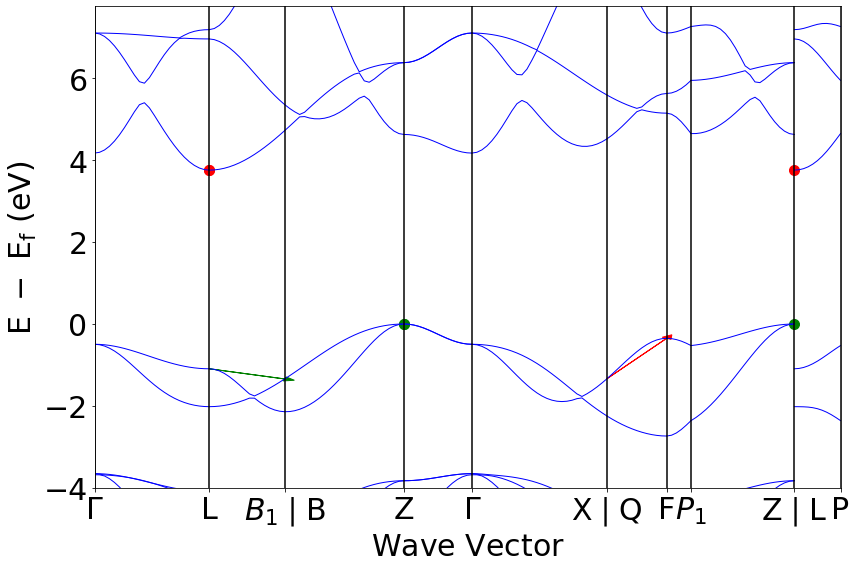

In [11]:
import pylab as p

plotter = BSPlotter(bandstructure)
plotter.get_plot(vbm_cbm_marker = True)
p.arrow(x_max_vb1, y_max_vb1, x_max_vb2 - x_max_vb1, y_max_vb2 - y_max_vb1, fc = "r", ec = "r", head_width = 0.1, head_length = 0.1)
p.arrow(x_min_vb1, y_min_vb1, x_min_vb2 - x_min_vb1, y_min_vb2 - y_min_vb1, fc = "g", ec = "g", head_width = 0.1, head_length = 0.1)
p.show()

Et de même pour montrer la direction dans laquelle la première bande de conduction présente le plus (en rouge) et le moins (en vert) de dispersion.

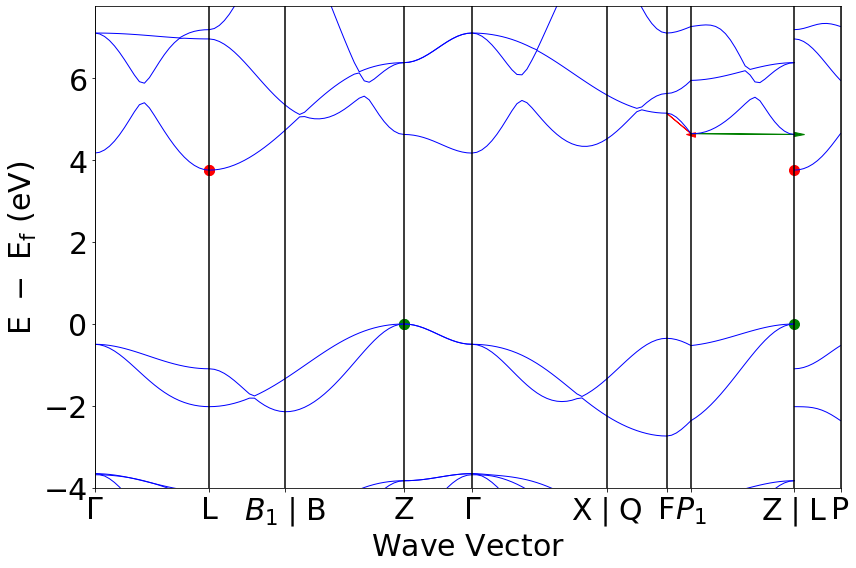

In [12]:
plotter = BSPlotter(bandstructure)
plotter.get_plot(vbm_cbm_marker = True)
p.arrow(x_max_cb1, y_max_cb1, x_max_cb2 - x_max_cb1, y_max_cb2 - y_max_cb1, fc = "r", ec = "r", head_width = 0.1, head_length = 0.1)
p.arrow(x_min_cb1, y_min_cb1, x_min_cb2 - x_min_cb1, y_min_cb2 - y_min_cb1, fc = "g", ec = "g", head_width = 0.1, head_length = 0.1)
p.show()

# Calcul de la masse effective via une approximation parabolique

Maintenant, on peut s'occuper des masses effectives. On considère un potentiel parabolique. C'est à dire que celui-ci est de le forme: $a\cdot x^2 + b\cdot x + c$. De plus, on sait que la masse effective vaut $m_e = \frac{\hbar^2}{\frac{\partial \epsilon^2}{\partial k^2}}$

In [13]:
# Calcul des différentes abscisses et ordonées pour l'qpproximation parabolique dans le cas du calcul de la masse effective 
# au sommet de la bande de valence

longueur_x = np.size(plotter.bs_plot_data()['distances'][2])
maxx = plotter.bs_plot_data()['distances'][3][0]
maxx_apres = plotter.bs_plot_data()['distances'][3][1]
maxx_avant = plotter.bs_plot_data()['distances'][2][longueur_x-2]

longueur_y = np.size(plotter.bs_plot_data()['energy'][2]['1'][10])
maxy = plotter.bs_plot_data()['energy'][3]['1'][10][0]
maxy_avant = plotter.bs_plot_data()['energy'][2]['1'][10][longueur_y-2]
maxy_apres = plotter.bs_plot_data()['energy'][3]['1'][10][1]

print(maxx_avant)
print(maxx)
print(maxx_apres)

print(maxy_avant)
print(maxy)
print(maxy_apres)

2.9735676887089157
3.0221187734053427
3.0694863957204785
-0.0026999999999999247
0.0
-0.00649999999999995


On peut donc calculer la masse effective au sommet de la bande de valence et vérifier que l'approximation parabolique est bonne en la plottant sur la structure de bande.

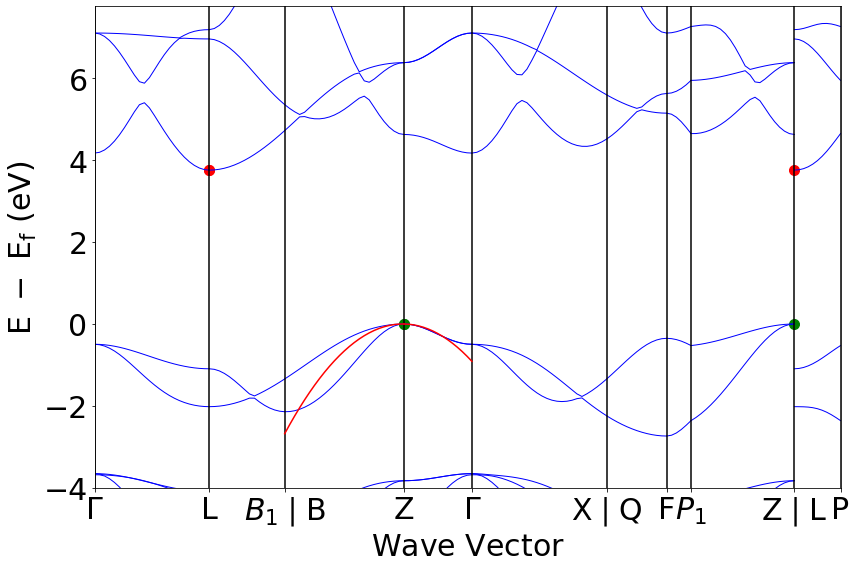

In [14]:
# utilisation de polyfit afin de faire une approximation parabolique
# polyfit utilisé sur 3 points dont le max de la dernière bande de valence, le point juste avant et juste après
pot_vb = np.polyfit(np.array([maxx_avant, maxx, maxx_apres]), np.array([maxy_avant, maxy, maxy_apres]), 2)

def f(x):
    return pot_vb[0]*x**2+ pot_vb[1]*x + pot_vb[2]

x1 = np.array(plotter.bs_plot_data()['distances'][3])
y1 = f(x1)
x2 = np.array(plotter.bs_plot_data()['distances'][2])
y2 = f(x2)


plotter = BSPlotter(bandstructure)
plotter.get_plot(vbm_cbm_marker = True)
plt.plot(x1,y1,"r-")
plt.plot(x2,y2,"r-")

La prochaine étape consiste à calculer la masse effective au sommet de la bande de valence. Comme dit plus haut, la masse effective vaut: $$m_e = \frac{\hbar^2}{\frac{\partial \epsilon^2}{\partial k^2}}$$
Etant donné que nous avons approximé notre potentiel par un potentiel parabolique, la dérivée seconde vaut $2\cdot a$.
Il faut juste faire attention au niveau des unités:
$2\cdot a$ est en [eV $\cdot \mathring{A}^2 $] et donc nous devons multiplier la dérivée seconde de l'énergie par la charge d'un électron et par $(10^{-10})^2$ pour avoir notre masse effective en kg.

In [15]:
from scipy import constants as cs

masse_eff_sommet_bv = (cs.hbar**2/(2*pot_vb[2]*1.602*10**(-19)*10**(-20)))

print("Ceci est la masse effective au sommet de la bande de valence: ", masse_eff_sommet_bv, "kg")

Ceci est la masse effective au sommet de la bande de valence:  -1.9035493630885829e-31 kg


On peut procéder de la même manière pour calculer la masse effective à la base de la bande de conduction:

In [16]:
# Calcul des différentes abscisses et ordonées pour l'qpproximation parabolique dans le cas du calcul de la masse effective 
# à la base de la bande de conduction

longueur_x_bc = np.size(plotter.bs_plot_data()['distances'][0])
maxx_bc = plotter.bs_plot_data()['distances'][1][0]
maxx_apres_bc = plotter.bs_plot_data()['distances'][1][1]
maxx_avant_bc = plotter.bs_plot_data()['distances'][0][longueur_x_bc-2]

longueur_y_bc = np.size(plotter.bs_plot_data()['energy'][0]['1'][11])
maxy_bc = plotter.bs_plot_data()['energy'][1]['1'][11][0]
maxy_avant_bc = plotter.bs_plot_data()['energy'][0]['1'][11][longueur_y_bc-2]
maxy_apres_bc = plotter.bs_plot_data()['energy'][1]['1'][11][1]

print(maxx_avant_bc)
print(maxx_bc)
print(maxx_apres_bc)

print(maxy_avant_bc)
print(maxy_bc)
print(maxy_apres_bc)

1.0714355871661436
1.1201372037462982
1.1692542420785932
3.7721000000000005
3.759
3.7642


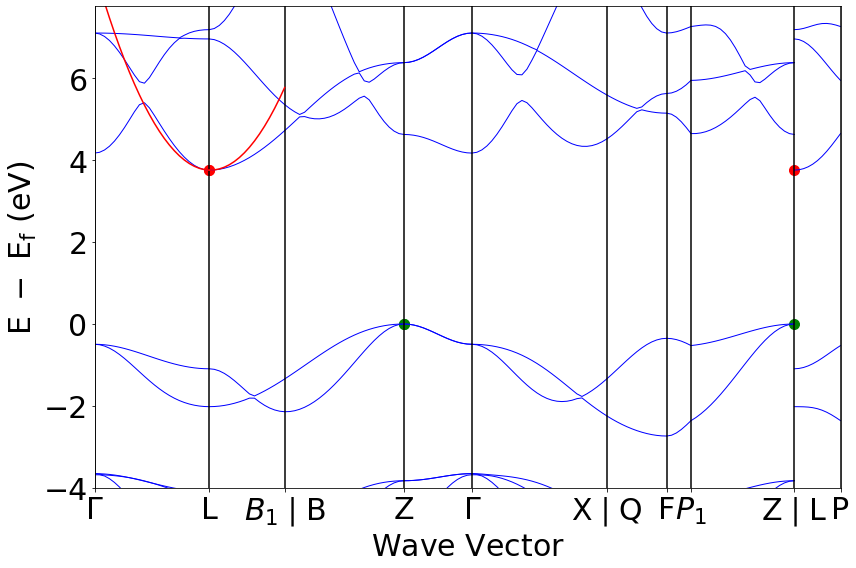

In [17]:
# utilisation de polyfit afin de faire une approximation parabolique
# polyfit utilisé sur 3 points dont le max de la première bande de conduction, le point juste avant et juste après
pot_bc = np.polyfit(np.array([maxx_avant_bc, maxx_bc, maxx_apres_bc]), np.array([maxy_avant_bc, maxy_bc, maxy_apres_bc]), 2)

def f(x):
    return pot_bc[0]*x**2+ pot_bc[1]*x + pot_bc[2]

x1_bc = np.array(plotter.bs_plot_data()['distances'][1])
y1_bc = f(x1_bc)
x2_bc = np.array(plotter.bs_plot_data()['distances'][0])
y2_bc = f(x2_bc)


plotter = BSPlotter(bandstructure)
plotter.get_plot(vbm_cbm_marker = True)
plt.plot(x1_bc,y1_bc,"r-")
plt.plot(x2_bc,y2_bc,"r-")

Comme précemment, il faut faire attention aux unités mais le calcul de la masse effective ainsi que le conversion en kg se font exactement de la même manière

In [210]:
masse_eff_sommet_bc = cs.hbar**2/(2*pot_bc[2]*1.602*10**(-19)*10**(-20))

print("Ceci est la masse effective à la base de la bande de conduction: ", masse_eff_sommet_bc, "kg")

Ceci est la masse effective à la base de la bande de conduction:  4.0083820785619945e-31 kg
